# EX1: Linear regression
 We first consider a simple linear regression model with a Gaussian likelihood. We compute the evidence for the model first with nested sampling, and then with the fourier integration method.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os, shutil
import numpy as np
import warnings
from matplotlib import pyplot as plt
import bilby
import logging
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list

CLEAN = False
OUTDIR = 'out_line'

if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(42)
warnings.filterwarnings("ignore")
logging.getLogger('bilby').setLevel(logging.CRITICAL)

## Generate some data

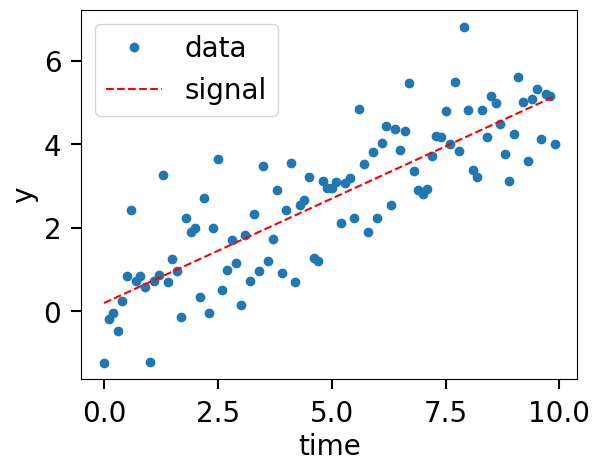

In [6]:
def model(time, m, c):
    return time * m + c

injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend();

## Nested sampling LnZ Calculation

In [7]:
class GaussianLikelihood(bilby.likelihood.Analytical1DLikelihood):
    def __init__(self, x, y, func, sigma=None, **kwargs):
        super(GaussianLikelihood, self).__init__(x=x, y=y, func=func, **kwargs)
        self.sigma = sigma

    def log_likelihood(self):
        return np.sum(- (self.residual / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)

likelihood = GaussianLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.Uniform(0, 5, "m"),
    c=bilby.core.prior.Uniform(-2, 2, "c")
))

label = 'linear_regression'
res_fn = f"{OUTDIR}/{label}_result.json"
if os.path.exists(res_fn):
    result = bilby.read_in_result(res_fn)
else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=1500,
        outdir=OUTDIR,
        label=label,
        injection_parameters=injection_parameters,
    )
lnz, lnz_err = result.log_evidence, result.log_evidence_err
print(f"LnZ: {lnz:.2f}+/-{lnz_err:.2f}")
print(f"lnBF: {result.log_bayes_factor}")
result.posterior.head()

1it [00:00, ?it/s]


LnZ: -143.62+/-0.08
lnBF: nan


,m,c,log_likelihood,log_prior
0,0.371619,0.960707,-144.432015,-2.995732
1,0.600449,-0.023405,-143.965399,-2.995732
2,0.630136,-0.349366,-143.885341,-2.995732
3,0.410890,0.399176,-143.800271,-2.995732
4,0.537964,0.386132,-143.491811,-2.995732


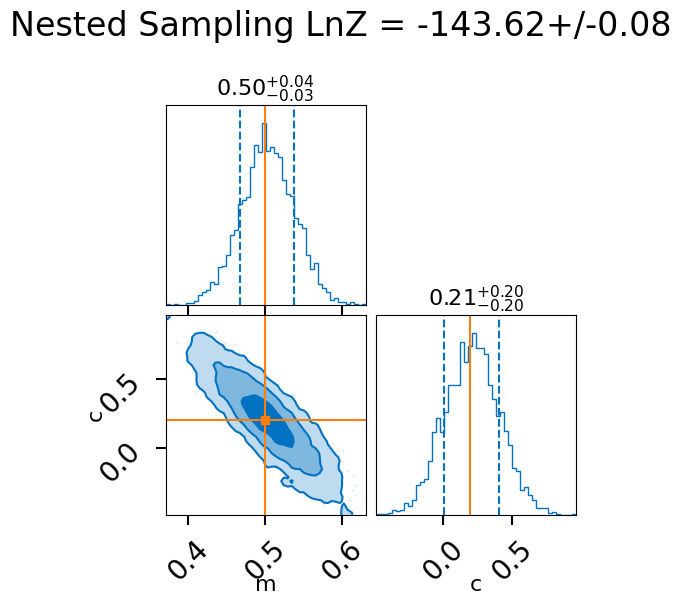

In [8]:
fig = result.plot_corner()
fig.suptitle(f"Nested Sampling LnZ = {lnz:.2f}+/-{lnz_err:.2f}", y=1.1);
fig

### FI LnZ calculation

In [33]:
lnz_file = f"{OUTDIR}/lnz.npz"
os.remove(lnz_file)
lnzs, r_vals, _  = get_fi_lnz_list(result.posterior, num_ref_params=100, cache_fn=lnz_file, )

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size:(4050, 2) 
|funnel|INFO| Posterior columns:
c
log_likelihood
log_prior
m 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

In [34]:
best_lnzs, _, best_sample  = get_fi_lnz_list(result.posterior, num_ref_params=1, weight_samples_by_lnl=True)

|funnel|INFO| Calculating FI LnZ with 1 reference points and a posterior of size:(4050, 2) 
|funnel|INFO| Posterior columns:
c
log_likelihood
log_prior
m 


FI LnZ:   0%|          | 0/1 [00:00<?, ?it/s, FI LnZ: 0]

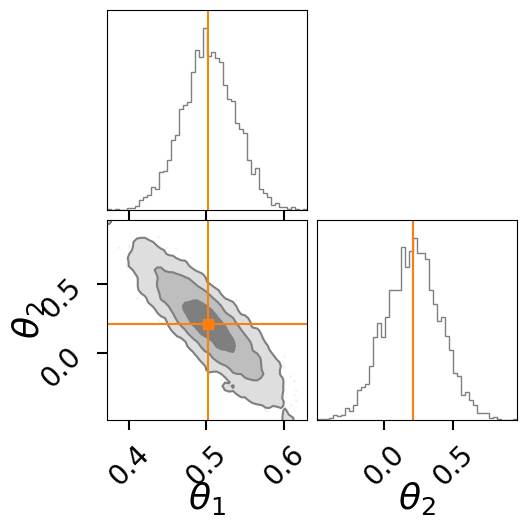

In [41]:
import matplotlib.pyplot as plt
import numpy as np


import corner

fig = result.plot_corner(color="tab:gray", truth=None, label_kwargs={"fontsize": 26}, quantiles=None, labels=[r"$\theta_1$",r"$\theta_2$"])

# overplot the FI points
for i, s in enumerate(best_sample):
    corner.overplot_lines(fig, s, color=f'C{i+1}')
    corner.overplot_points(fig, [[np.nan if t is None else t for t in s]],color=f'C{i+1}', marker='s', markersize=7)
fig

/tmp/ipykernel_592353/845767860.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


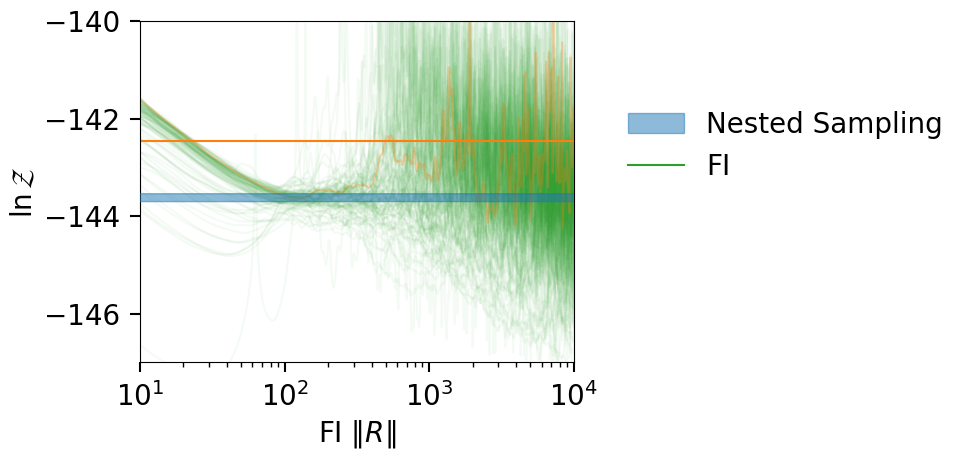

In [39]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[lnz + lnz_err, lnz - lnz_err], )

fig = plot_fi_evidence_results(**plt_kwgs,plot_all_lnzs=True,plot_ci=False)
ax = fig.gca()
ax.plot(r_vals, best_lnzs.ravel(), color='C1', alpha=0.3)
ax.axhline(np.median(best_lnzs), color='C1')
ax.set_xlim(10, 10000)
ax.set_ylim(-147, -140)
fig.tight_layout()

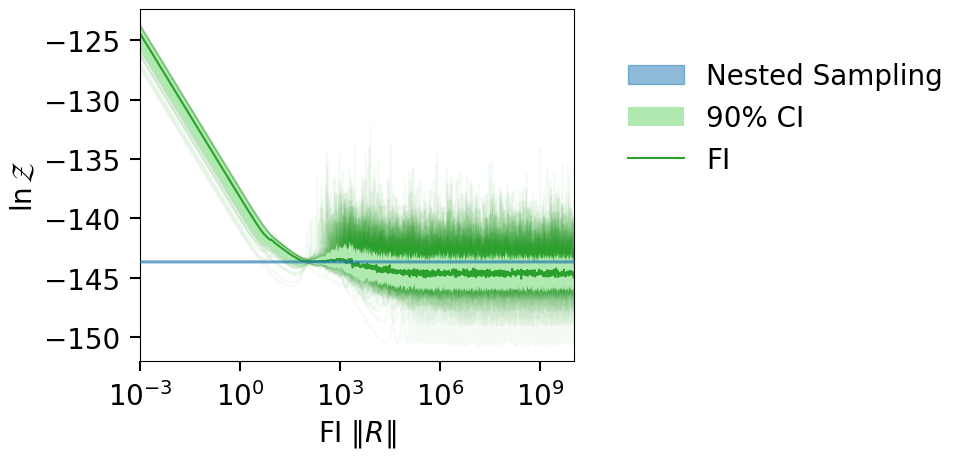

In [8]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True)
fig.tight_layout()

HI


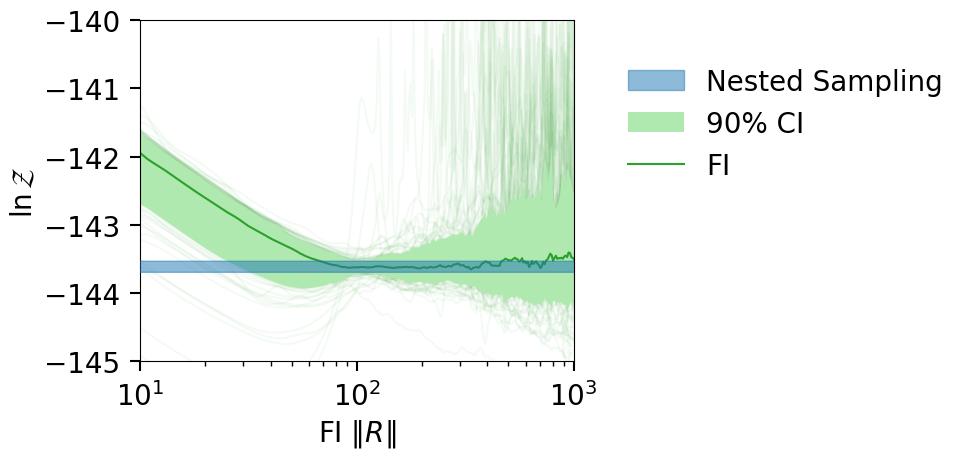

In [10]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True)
ax = fig.gca()
ax.set_xlim(10, 1e3)
ax.set_ylim(-145, -140)
fig.tight_layout()

## Comparing FI LnZ values

Here we compare two FI LnZ vs R curves for two different set of reference points.

|funnel|INFO| Calculating FI LnZ with 2 reference points and a posterior of size: (3923, 2) 


FI LnZ:   0%|          | 0/2 [00:00<?, ?it/s, FI LnZ: 0]

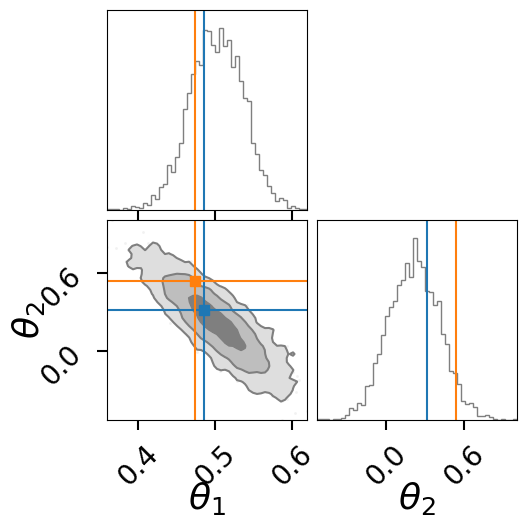

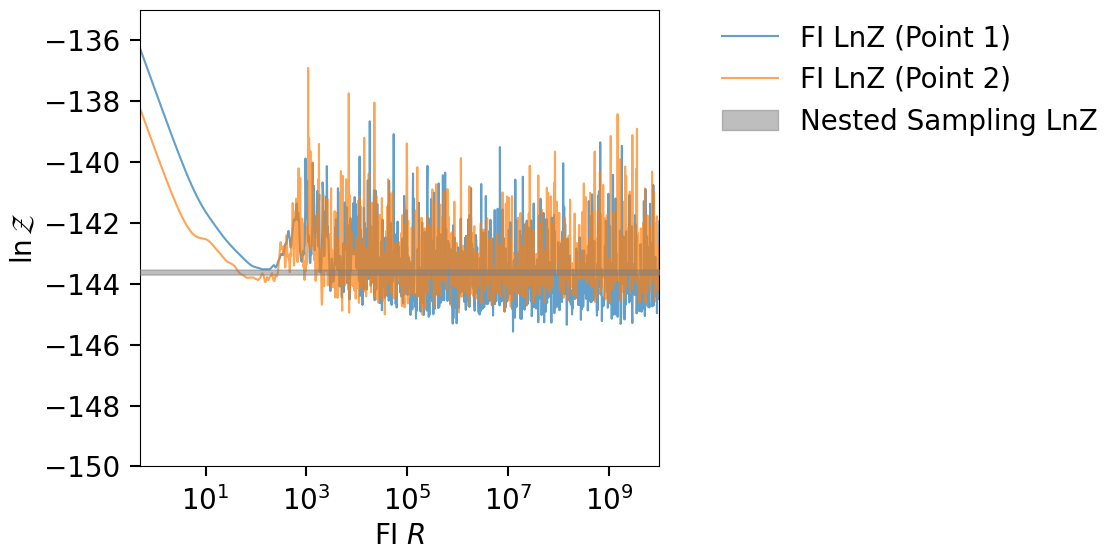

In [25]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

sampling_lnz, sampling_lnz_lnz_err = result.log_evidence, result.log_evidence_err
sampling_lnz = [sampling_lnz + sampling_lnz_lnz_err, sampling_lnz - sampling_lnz_lnz_err]


lnzs, r_vals, fi_samp = get_fi_lnz_list(result.posterior, num_ref_params=2)

plt.figure(figsize=(12, 6))
for i, lnz in enumerate(lnzs):
    plt.plot(r_vals, lnz, label=f"FI LnZ (Point {i + 1})", alpha=0.7)
plt.xscale("log")
plt.xlim(0.5, max(r_vals))
plt.ylim(-150, -135)
plt.xlabel(r"FI $R$")
plt.ylabel(r"$\ln{\mathcal{Z}}$")

plt.fill_between(
            x=r_vals,
            y1=min(sampling_lnz),
            y2=max(sampling_lnz),
            color="tab:gray",
            interpolate=True,
            alpha=0.5,
            label="Nested Sampling LnZ",
            zorder=10,
        )
plt.legend(loc=(1.1, 0.7), frameon=False)
plt.tight_layout()



import corner

fig = result.plot_corner(color="tab:gray", truth=None, label_kwargs={"fontsize": 26}, quantiles=None, labels=[r"$\theta_1$",r"$\theta_2$"])

# overplot the FI points
for i, s in enumerate(fi_samp):
    corner.overplot_lines(fig, s, color=f'C{i}')
    corner.overplot_points(fig, [[np.nan if t is None else t for t in s]],color=f'C{i}', marker='s', markersize=7)
fig